# Image Classification Model Training

### What TensorFlow trains

TensorFlow doesn’t force one type of model — you can define your own.
* But for image classification, the most common model is a Convolutional Neural Network (CNN).
* CNNs are especially good at finding patterns in images (edges, textures, shapes).
* TensorFlow + its high-level API Keras makes building CNNs very straightforward.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("TensorFlow:", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

Numpy: 2.3.2
Pandas: 2.3.2
Matplotlib: 3.10.6
TensorFlow: 2.20.0


numpy is a library that provides easy calculations. matplotlib provides plots. pandas helps with loading, cleaning, exploring and preparing data in csv or tabular formats. 

Tensorflow is a ML/DL framework by google that can be used for simple tasks or neural networks of any level. keras is an api that is fully integrated with tf. If tf is an engine(Complex), keras is like a steering wheel/dashboard(easy to use). If tf is a toolbox, keras is an assistant that hands out the tools we need.

### Verifying the path to the dataset

In [2]:
data_train_path = 'Fruits_Vegetables/train'
data_test_path = 'Fruits_Vegetables/test'
data_val_path = 'Fruits_Vegetables/validation'

### setting the images in a similar size

Neural networks expect all inputs to have the same shape.

Why resizing matters
* Consistency → CNN layers need fixed input dimensions.
* Memory → Bigger images = more pixels = more computations.
* Speed → Smaller images train faster (but might lose detail).

In [3]:
img_width = 180
img_height = 180 

### Loading and batching the training dataset

In [4]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 3115 files belonging to 36 classes.


##### tf.keras.utils.image_dataset_from_directory()

This function creates a dataset from images stored in folders.
it assumes:

    data_train_path/
        apple/
            apple1.jpg
            apple2.jpg
        banana/
            banana1.jpg
            banana2.jpg
        tomato/
            tomato1.jpg
            tomato2.jpg

Each subfolder name becomes a label automatically.
* apple/ → class 0
* banana/ → class 1
* tomato/ → class 2

##### shuffle=True

Randomly shuffles the images before batching.

Important so the model doesn’t see all apples first, then all bananas — it learns better when classes are mixed.

##### batch_size=32

Groups images into batches of 32.

Instead of training one image at a time (too slow), the model sees 32 at once, processes them in parallel, and updates weights after each batch.

##### validation_split=False

By default, this function can split your dataset into training and validation sets.

Since it’s set to False, it means you’re not splitting here — all images in this directory will be used for training.

### The data Classes

In [5]:
data_cat = data_train.class_names

In [6]:
data_cat

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

### Loading and batching the Validation dataset

In [7]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,
    validation_split=False
)

Found 351 files belonging to 36 classes.


### Loading and batching the testing dataset

In [8]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 359 files belonging to 36 classes.


### Printing a sample from the training dataset

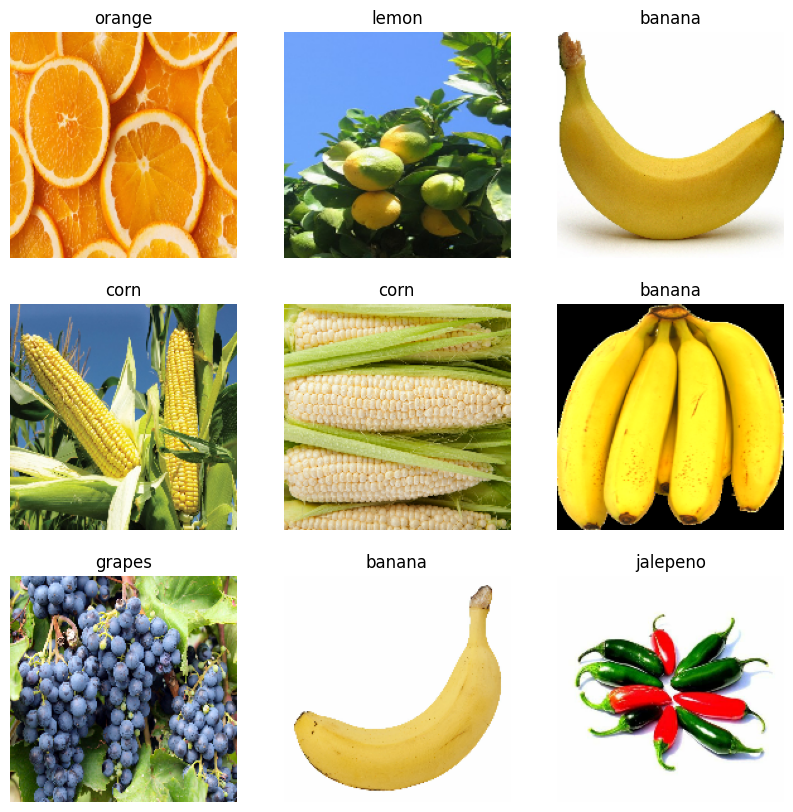

In [9]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

##### plt.figure(figsize=(10,10))
* Creates a blank figure with size 10×10 inches (so the grid of images isn’t tiny).

##### for image, labels in data_train.take(1):
* grabs 1 batch of data from your dataset.
Since your batch size is 32, this batch has 32 images + 32 labels.

The loop unpacks that batch into:
* image → the 32 images (a tensor).
* labels → the 32 class labels (numbers like 0, 1, 2...).

for i in range(9): - You only want to show the first 9 images from that batch.

plt.subplot(3,3,i+1) - Makes a grid of 3 rows × 3 columns.
i+1 ensures it fills the subplots from 1 to 9.

##### plt.imshow(image[i].numpy().astype('uint8'))
* Takes the i-th image from the batch.
* .numpy() converts it from a TensorFlow tensor → NumPy array (so matplotlib can use it).
* .astype('uint8') makes sure pixel values are integers between 0–255 (standard image format).
* Displays the image.

##### plt.title(data_cat[labels[i]])
* labels[i] is the numeric class (e.g., 0).
* data_cat is likely a list of class names (like ["apple", "banana", "tomato"]).
* So data_cat[0] = "apple" → gives you a human-readable label for the title.

plt.axis('off') - Removes the x/y axis ticks (since you don’t need them for images).

### Building the Sequential model

In [10]:
from tensorflow.keras.models import Sequential

In [11]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

This is a CNN classifier:

* First layers → extract features (edges → shapes → textures).
* Flatten + Dense → interpret those features.
* Final Dense → output class scores.

In [12]:
model = Sequential([ #stacking layers one after another in a straight line.
    layers.Rescaling(1./255), #divides every pixel by 255 → normalizes the input
    layers.Conv2D(16, 3, padding='same', activation='relu'), #a convolutional layer, which looks for patterns in the image.
    layers.MaxPooling2D(), #This reduces size, keeps important features, and makes the model faster
    layers.Conv2D(32,3, padding='same',activation='relu'), #Now with 32 filters → 
    layers.MaxPooling2D(), #deeper patterns (like corners, blobs).
    layers.Conv2D(64, 3, padding='same', activation='relu'), #64 filters
    layers.MaxPooling2D(), #complex features (like shapes, textures)
    layers.Flatten(), #2D feature flattens to 1D vector - 10×10×64 tensor turns to a vector of 6400 values
    layers.Dropout(0.2), #Randomly turns off 20% of neurons during training - Prevents overfitting
    layers.Dense(128), # A fully connected (Dense) layer with 128 neurons - decision-making part
    layers.Dense(len(data_cat)) #Final output layer
])

model.compile() is basically telling Keras:

* How to measure error → loss function
* How to fix errors → optimizer
* What to track for performance → metrics

After this, your model is ready for model.fit() to actually train on your images.

In [13]:
model.compile(
    optimizer='adam', #decides how the model updates its weights during training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    #Loss function measures how wrong the model’s predictions are compared to true labels
    #SparseCategoricalCrossentropy is used when: more than 2 classes or labels are integers (like 0, 1, 2…)
    #from_logits=True tells TF: last layer doesn’t have softmax activation. outputs are raw scores (logits)
    metrics=['accuracy'] #what you monitor during training.
    #'accuracy' means Keras will report the percentage of correct predictions after each epoch.
)

### Training Process

model.fit() is where the model actually learns from your images.

Training = improving weights

Validation = monitoring generalization

Epochs = how many times you cycle through the data

In [14]:
epochs_size = 25
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 448ms/step - accuracy: 0.0604 - loss: 3.7728 - val_accuracy: 0.1453 - val_loss: 2.9762
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - accuracy: 0.2552 - loss: 2.7332 - val_accuracy: 0.6353 - val_loss: 1.6047
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - accuracy: 0.4902 - loss: 1.8027 - val_accuracy: 0.8234 - val_loss: 0.7584
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - accuracy: 0.7047 - loss: 1.0638 - val_accuracy: 0.9088 - val_loss: 0.4799
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 34s 344ms/step - accuracy: 0.8440 - loss: 0.5654 - val_accuracy: 0.9288 - val_loss: 0.4446
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - accuracy: 0.8925 - loss: 0.3996 - val_accuracy: 0.9402 - val_loss: 0.4144
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.9223 - loss: 0.3118 - val_accuracy: 0.9459 - val_loss: 0.3248
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.9352 - loss: 0.2351 - val_accu

Text(0.5, 1.0, 'Loss')

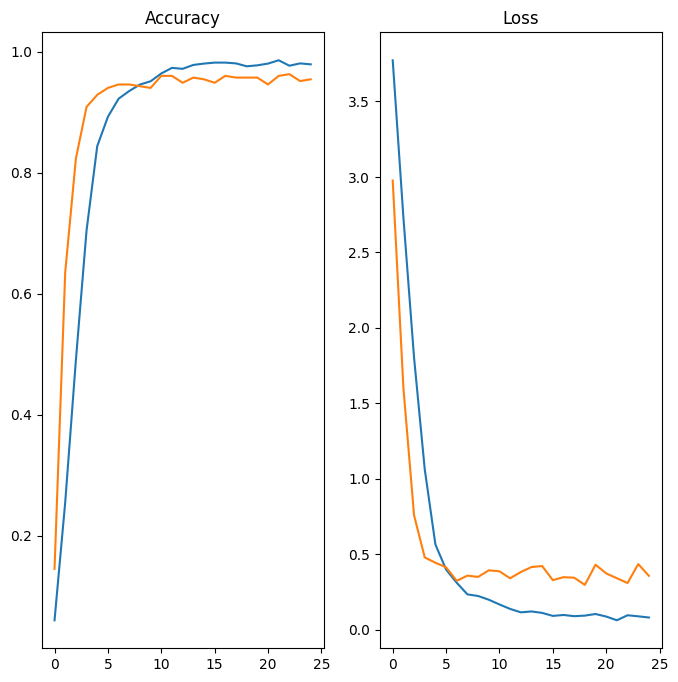

In [15]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

### Predicting values

In [19]:
image = 'images/corn.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [20]:
predict = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [21]:
score = tf.nn.softmax(predict)

In [22]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is corn with accuracy of 96.11


In [23]:
model.save('Image_classify.keras')